# Metaheuristicas para la solución del TSP


Este notebook presenta uno de los problemas clásicos de la optimización matemática, el problema del vendedor viajero o Traveling Salesman Problem (TSP por sus siglas en inglés). En la primera parte se dará una pequeña introducción al problema y luego este se resolverá usando algunas de las metaheurísticas vistas en clase. Adicionalmente, se presentará la solución óptima al problema usando uno de los dos solvers propuestos en clase (Gurobi). Se verá, que para pequeñas instancias, hallar la solución óptima es muy sencillo, pero cuando el tamaño de la instancia crece, resolver el problema se vuelve computacionalmente costoso. Este recurso se construyó haciendo uso de algunos tutoriales como [1], [2], [3].  

## Introducción al problema del TSP

En el problema del vendedor viajero tenemos un vendedor que debe hacer un recorrido en el cual visite diferentes ciudades (clientes) y retorne a la ciudad de origen. El objetivo es encontrar la ruta mas corta que le permira visitar todas las ciudades, sin visitar dos veces una misma ciudad, minimizando la distancia del viaje. Este problema es común asociarlo a los conocidos problemas de ruteo en redes de computadores. Este problema es muy sencillo de explicar pero complicado de resolver, ya se verá porque. 

Puede encontrar información más detallada sobre el TSP en el libro The Traveling Salesman Problem: A Computational Study [4], o en la página web del TSP [5]. Si está interesado en la historia y los antecedentes matemáticos del TSP, le recomendamos que vea el vídeo de William Cook [6].

## Formulación matemática del TSP 

El problema TSP se puede definir de la siguiente manera: para una lista dada de ciudades y las distancias entre cada par de ellas, se quiere encontrar la ruta más corta posible que vaya a cada ciudad una vez y vuelva a la ciudad de origen.

Existe una clase de TSP que asume que la distancia de ir de la ciudad $i$ a la ciudad $j$ es la misma que ir de la ciudad $j$ a la ciudad $i$, este tipo de problema se conoce como el problema TSP simétrico. En este ejemplo, utilizamos las distancias euclidianas, pero la formulación del modelo TSP es válida independientemente de la forma en que se determinen las distancias individuales.

Recordemos que un modelo de optimización matemática está definido por cinco componentes principales: 

* Conjuntos e índices.
* Parámetros.
* Variables de decisión.
* Función(es) objetivo.
* Restricciones.

A continuación presentamos una formulación *MIP* del TSP que identifica la ruta más corta que va a todas las ciudades una vez y vuelve a la ciudad origen.

**Pregunta: Porque es una formulacion *MIP*?**

### Conjuntos e índices

Sean: 
* $i, j \in Ciudades $: los índices y conjunto de ciudades a visitar. 
* $\text{Caminos}= \{(i,j) \in Ciudades \times Ciudades \}$: Conjunto permitido de caminos entre ciudades.
* $S \subset Ciudades$: Un subconjunto del conjunto de ciudades.
* $G = (Ciudades, Caminos)$: Un grafo en el que el conjunto $Ciudades$ define el conjunto de nodos y el conjunto $Caminos$ define el conjunto de aristas. 

### Parámetros

Sean: 
* $d_{i, j} \in \mathbb{R}^+$: Distancia de la ciudad $i$ a la ciudad $j$, para todas las $(i, j) \in Caminos$. 

Obsérvese que la distancia de la ciudad $i$ a la ciudad $j$ es la misma que la distancia de la ciudad $j$ a la ciudad $i$, es decir, $d_{i, j} = d_{j, i}$. Por esta razón, este TSP también se denomina TSP simétrico.

### Variables de decisión

* $x_{i, j} \in \{0, 1\}$: Esta variable es igual a 1, si decidimos conectar la ciudad $i$ con la ciudad $j$. En caso contrario, la variable de decisión es igual a cero.

### Función objetivo

- **Ruta más corta**. Minimizar la distancia total de una ruta. Una ruta es una secuencia de ciudades donde el vendedor visita cada ciudad una sola vez y vuelve a la ciudad de partida.

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in \text{Caminos}}d_{i,j} \cdot x_{i,j}
\tag{0}
\end{equation}

### Restricciones
- **Restricciones de simetría**. Para cada par $(i,j)$, asegurar que las ciudades $i$ y $j$ están conectadas, si la primera es visitada inmediatamente antes o después de visitar la segunda.

\begin{equation}
x_{i, j} = x_{j, i} \quad \forall (i, j) \in Caminos
\tag{1}
\end{equation}

- **Entrada y salida de una ciudad**. Para cada ciudad $i$, asegúrese de que esta ciudad está conectada a otras dos ciudades. 

\begin{equation}
\sum_{(i,j) \in \text{Caminos}}x_{i,j} = 2 \quad \forall  i \in Ciudades
\tag{2}
\end{equation}

- **Eliminación de subrutas**. Estas restricciones aseguran que para cualquier subconjunto de ciudades $S$ del conjunto de $Ciudades$, no haya ningún ciclo. Es decir, no hay ninguna ruta que visite todas las ciudades del subconjunto y vuelva a la ciudad de origen. Esto es similar a encontrar un ciclo Hamiltoniano y en clase se explicó que es NP-completo. 

\begin{equation}
\sum_{(i \neq j) \in S}x_{i,j} \leq |S|-1 \quad \forall  S \subset  Ciudades
\tag{3}
\end{equation}


- **Nota**. En general, si el número de ciudades del TSP es $n$, entonces el número posible de rutas es n\!. Dado que hay un número exponencial de restricciones ($2^{n} - 2$) para eliminar los ciclos, relajamos las restricciones para eliminar dinámicamente esos ciclos.

## Implementación

Imaginemos un vendedor que tiene que visitar a sus clientes en la ciudades capitales de cada uno de los estados de los Estados Unidos. El vendedor quiere identificar la ruta más corta que va a todas las capitales de los estados.

Este ejemplo de modelado requiere las siguientes librerias que no forman parte de la distribución estándar de Python:

* **folium**: para crear mapas.
* **gurobipy**: proporciona algoritmos de Gurobi para resolver modelos MIP.
* **OR-Tools**: proporciona algoritmos para la solucion de problemas de optimización combinatoria.  

### Generación de los datos de entrada

Los datos de entrada contienen las ciudades capitales de los Estados Unidos. El archivo esta estructurado en formato json. Consta del nombre del estado, la capital y las coordenadas de la capital (latitud y longitud). Para saber más acerca del formato json, diríjase a [7]. 

De este archivo podemos obtener la información necesaria para formar los conjuntos de $Ciudades$ y $Caminos$. Note que haremos una simplificación al asumir que la distancia entre dos ciudades es una línea recta. Esta suposición es falsa la mayor parte del tiempo puesto que las ciudades están conectadas por carreteras o autopistas que no siempre son rectas. 

Como lo que se encuentra en el archivo es la ubicación de las ciudades por medio de sus coordenadas, debemos calcular la distancia entre ellas para generar el conjunto de caminos. 

In [1]:
import json
import math
from itertools import combinations

# Leemos los datos de las ciudades capitales del archivo US_capitals.json
capitals_json = json.load(open('../source/data/US_capitals.json'))

# Generamos el conjunto de ciudades y sus coordenadas para luego calcular la distancia entre ellas. 
capitals = []
coordinates = {}
for state in capitals_json:
    # Alaska y Hawai se eliminan de la ruta porque no son factibles (ej., a Hawai se debe viajar por bote)
    if state not in ['AK', 'HI']:
        capital = capitals_json[state]['capital']
        capitals.append(capital)
        coordinates[capital] = (float(capitals_json[state]['lat']), float(capitals_json[state]['long']))

        
# La siguiente función calcula la distancia entre cualquier par de ciudades. Como estamos solucionando el 
# TSP simétrico, debemos usar una combinación de ciudades (ej., Phoenix-Denver, Denver-Phoenix)
def distance(city1, city2):
    # distancia a otra ciudad usando la formula de Haversine, vea http://www.movable-type.co.uk/scripts/latlong.html
    c1 = coordinates[city1]
    c2 = coordinates[city2]
    diff = (c1[0]-c2[0], c1[1]-c2[1])
    
    lat = math.radians(diff[0])
    long = math.radians(diff[1])
    
    a = math.pow(math.sin(lat/2), 2) + math.cos(math.radians(c1[0])) * math.cos(math.radians(c2[0])) * pow(math.sin(long/2), 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    radius_earth = 6378.7 # in kilometers
    return radius_earth * c

# Ahora si, podemos crear la matriz de distancias (o el conjunto de caminos)
dist = {(c1, c2): distance(c1, c2) for c1, c2 in combinations(capitals, 2)}

Note que la matriz de distancias es explícitamente calculada para ahorrar tiempo. En este ejemplo calculamos la distancia usando la fórmula de la distancia euclidiana $\sqrt{(x_i-x_j)^2+(y_i-y_j)^2}$.

Teniendo listos los datos de entrada, procedemos a generar el modelo. Primero se hará para Gurobi y luego se mostrará como solucionar el problema con algunas metaheurísticas. 

### Solución óptima: Gurobi

Se debe definir primero las las variables de decisión, las restricciones y la función objetivo. Dado que este es el TSP simétrico, podemos hacerlo más eficiente estableciendo el $x[j,i]$ como $x[i,j]$, en lugar de añadir una restricción.

In [2]:
import gurobipy as gp
from gurobipy import GRB

# probado con Python 3.8 & Gurobi 9.1.2 con licencia académica

m = gp.Model()

# Variables: es la ciudad 'i' adjacente a la ciudad 'j' en la ruta?
vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='x')

# Restricciones de simetría: copie x[j, i] como x[i, j]
for i, j in vars.keys():
    vars[j, i] = vars[i, j]  # edge in opposite direction

# Entrada y salida de una ciudad: dos aristas por ciudad
cons = m.addConstrs(vars.sum(c, '*') == 2 for c in capitals)

Academic license - for non-commercial use only - expires 2021-09-09
Using license file /Users/paola/gurobi.lic


Las restricciones de subrutas evitan los ciclos múltiples en un recorrido TSP. Como hay un número exponencial de estas restricciones, no queremos añadirlas todas al modelo. En su lugar, utilizamos una función callback para encontrar las restricciones de subruta violadas y añadirlas al modelo como una relajación de las mismas (se permiten subrutas en la solucion y se eliminan después).

In [3]:
# Callback - use relajaciones para eliminar las subrutas. 

def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # hacemos una lista de las aristas seleccionadas en la solucion. 
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys()
                             if vals[i, j] > 0.5)
        # encontramos el ciclo mas corto en la lista de las aristas
        tour = subtour(selected)
        if len(tour) < len(capitals):
            # añadimos la restricción que elimina las subrutas para cada par de ciudades en la ruta.
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# Dada una lista de tuplas de aristas, encuentre la subruta mas corta.
def subtour(edges):
    unvisited = capitals[:]
    cycle = capitals[:] 
    while unvisited:  # verdadero si la lista contiene algún elemento
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # New shortest subtour
    return cycle

In [4]:
# Resolvemos el modelo

m._vars = vars
m.Params.lazyConstraints = 1
m.optimize(subtourelim)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 48 rows, 1128 columns and 2256 nonzeros
Model fingerprint: 0xa3a414dc
Variable types: 0 continuous, 1128 integer (1128 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 48 rows, 1128 columns, 2256 nonzeros
Variable types: 0 continuous, 1128 integer (1128 binary)

Root relaxation: objective 1.617266e+04, 75 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 16172.6562    0   14          - 16172.6562      -     -    0s
H    0     0                    19282.751766 16172

In [5]:
# Verificamos que la solución encontrada si visite todas las ciudades y retorne a la ciudad de origen. 

# retornamos la solución
vals = m.getAttr('x', vars)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

# encontramos la ruta mas corta y verificamos que visite todas las ciudades 
tour = subtour(selected)
print(f"La ruta mas corta es: {tour}")
print("Con una distancia de: {:>8.2f} km".format(m.ObjVal))
assert len(tour) == len(capitals)


# mostramos la solución. 
import folium

map = folium.Map(location=[40,-95], zoom_start = 4)

points = []
for city in tour:
    points.append(coordinates[city])
points.append(points[0])

folium.PolyLine(points).add_to(map)

map

La ruta mas corta es: ['Montgomery', 'Tallahassee', 'Columbia', 'Raleigh', 'Richmond', 'Annapolis', 'Dover', 'Trenton', 'Hartford', 'Providence', 'Boston', 'Concord', 'Augusta', 'Montpelier', 'Albany', 'Harrisburg', 'Charleston', 'Columbus', 'Lansing', 'Madison', 'Saint Paul', 'Bismarck', 'Pierre', 'Cheyenne', 'Denver', 'Salt Lake City', 'Helana', 'Boise', 'Olympia', 'Salem', 'Sacramento', 'Carson City', 'Phoenix', 'Santa Fe', 'Oklahoma City', 'Austin', 'Baton Rouge', 'Jackson', 'Little Rock', 'Jefferson City', 'Topeka', 'Lincoln', 'Des Moines', 'Springfield', 'Indianapolis', 'Frankfort', 'Nashville', 'Atlanta']
Con una distancia de: 17112.75 km


**Ejercicio propuesto: OR-Tools también soluciona este problema de manera diferente. Implemente la solucion propuesta en [8] haciendo uso de los datos acá mostrados. Verifique que ambos solvers llegan a la misma solución.**

**Ejercicio propuesto: En la formulación anterior usamos algunas relajaciones para encontrar la ruta más corta que no contenga ciclos (óptimo), compruebe que si no se introducen dichas relajaciones, el problema se vuelve irresoluble para instancias grandes del problema (un ruta que incluya todas las ciudades)**

### Solución al TSP usando Recocido Simulado
El recocido simulado es una técnica de optimización que encuentra una aproximación al mínimo global de una función. Cuando se trabaja en un problema de optimización, se diseña un modelo y una función de coste específica para este problema. Aplicando la técnica del trecocido simulado a esta función de coste, se puede encontrar una solución óptima (no se garantiza). 

Recordemos que el recocido simulado, simula un proceso metalúrgico y encuentra niveles de energía más bajos para la función de coste. El algoritmo comienza con una temperatura alta y se enfría lentamente hasta llegar a una temperatura baja. El enfriamiento se realiza simplemente con un ciclo sobre una variable de temperatura, y multiplicando esta variable por un número entre 0 y 1 (factor de enfriamiento) en cada iteración, siguiendo el siguiente algoritmo. 

```
temperatura_actual = temperatura_inicial
while temperatura_actual > temperatura_final:
    compute valor del costo y actualice la solución óptima
    temperatura_actual = temperatura_actual * factor_enfriamiento
```

En el problema del TSP lo que queremos es minimizar la distancia, por lo tanto ella será nuestra función de coste. Los parámetro de esta función son las ciudades en la lista. Modificar un parámetro de la lista equivale a cambiar el orden en el que se visitan las ciudades. Aplicar el recocido simulado al TSP se puede hacer de la siguiente manera. 

* Empezaremos por generar una solución inicial, puede ser un orden aleatorio de las ciudades. 
* En cada iteración, un par de ciudades son intercambiadas en la lista. El valor de la función de costo es la distancia viajada por el vendedor. 
* Si la nueva distancia, calculada tras el cambio, es más corta que la actual, se mantiene.
* Si la nueva distancia es más larga que la actual, se mantiene con una cierta probabilidad.
* Actualizamos la temperatura en cada iteración enfriando lentamente.

Para acelerar este proceso se pueden hacer dos modificaciones: 
* En lugar de volver a calcular la distancia entre dos ciudades cada vez que se requiera, se pueden precalcular las distancias entre todos los pares de ciudades en una tabla, y utilizarlas a partir de entonces. En realidad, basta con una matriz triangular, ya que el TSP que estamos resolviendo es simétrico (la distancia entre las ciudades $i$ y $j$ es la misma que la distancia entre $j$ e $i$.
* Como un cambio de parámetros consiste en intercambiar dos ciudades, es inútil volver a calcular la distancia total para todo el recorrido. De hecho, sólo hay que volver a calcular las distancias modificadas por el intercambio.


In [6]:
import random
import time
import matplotlib.pyplot as plt


# en el ejemplo anterior solo calculamos la distacia entre ciudades (i,j) 
# para economizar en código, añadiremos también entre las ciudades (j,i)
for c1, c2 in combinations(capitals, 2):
    dist[(c2, c1)] = distance(c2, c1)

def total_distance_in_km(cities):
    distances = []
    for index in range(len(cities)):
        # solo calculamos la distancia para las ciudades (i, j) pero es la misma distancia que (j, i)
        current_city = cities[index]
        next_city = cities[(index + 1) % len(cities)]
        distances.append(dist[(current_city, next_city)])    
    return sum(distances)

def compute_swap_indices(index, nb_cities):
    index_previous = (index - 1 + nb_cities) % nb_cities
    index_next = (index + 1) % nb_cities
    return (index_previous, index_next)

def distance_swap(cities, index_a, index_b):
    """Calcula la distancia inferida por los dos índices dados."""
    index_A = min(index_a, index_b)
    index_B = max(index_a, index_b)
    
    (index_A_previous, index_A_next) = compute_swap_indices(index_A, len(cities))
    (index_B_previous, index_B_next) = compute_swap_indices(index_B, len(cities))
  
    distances = []
    # Estas dos distancias son comunes a los dos subcasos
    city_A = cities[index_A]
    city_A_previous = cities[index_A_previous]
    city_A_next = cities[index_A_next]
    
    city_B = cities[index_B]
    city_B_next = cities[index_B_next]
    city_B_previous = cities[index_B_previous]
    
    distances.append(dist[(city_A_previous, city_A)])
    distances.append(dist[(city_B, city_B_next)])        

    if index_A == index_B_previous:
        # B sigue a A en la lista: la distancia entre A y B no debe
        # ser contada dos veces.
        # ---x---A---B---x---
        distances.append(dist[(city_A, city_B)])
    else:
        # B no sigue a A en la lista: hay que contar todas las distancias
        # ---x---A---x--- ... ---x---B---x---
        distances.append(dist[(city_A, city_A_next)])
        distances.append(dist[(city_B_previous, city_B)])

    return sum(distances)


def annealing(cities, temperature_begin=1.0e+300, temperature_end=.1, cooling_factor=.99, nb_iterations=1):
    """
    Función que implementa el Recocido Simulado con probabilidad de aceptación y reinicio, como en 
    Kirkpatrick et al.

    distance_best:    mejor solución encontrada hasta el momento
    distance_current: solución usada en la actual simulación
    distance_new:     solución calculada haciendo cambios a la actual
    """

    cities_best = cities[:]
    distance_best = total_distance_in_km(cities_best)

    distances_current = []
    distances_best = []
    ids_iteration = []

    try:
        for iteration in range(nb_iterations):
            # la búsqueda se reinicia cada iteración desde la mejor solución conocida
            temperature = temperature_begin
            cities_current = cities_best[:]
            distance_current = distance_best
            distance_new = distance_best
            cities_new = cities_best[:]

            step = 0
            while temperature > temperature_end:
                # calcule los índices de las dos ciudades a ser intercambiadas aleatoriamente,
                # pero nunca cambie la primera ciudad del recorrido (no necesita cambiar)
                index = random.sample(range(len(cities_new) - 1), 2)
                index[0] += 1
                index[1] += 1

                # optimice volviendo a calcular sólo las distancias modificadas
                swap_before = distance_swap(cities_new, index[0], index[1])
                cities_new[index[0]], cities_new[index[1]] = cities_new[index[1]], cities_new[index[0]]
                swap_after = distance_swap(cities_new, index[0], index[1])

                # calcular la nueva distancia
                # volver a calcular todo no es eficiente: distancia_nueva = total_distancia_en_km(ciudades_nuevas)
                distance_new = distance_new - swap_before + swap_after

                # probabilidad de aceptación, por Kirkpatrick et al.
                diff = distance_new - distance_current
                if diff < 0 or  math.exp( -diff / temperature ) > random.random():
                    cities_current = cities_new[:]
                    distance_current = distance_new
                else:
                    # reinicie las ciudades y la distancia
                    distance_new = distance_current
                    cities_new = cities_current[:]

                # actualizar la mejor solución si la solución actual es mejor
                # no forma parte del recocido en sí, sólo se utiliza para el reinicio
                if distance_current < distance_best:
                    cities_best = cities_current[:]
                    distance_best = distance_current

                if True:
                    # si step % 100 == 0:
                    # descomente para habilitar el muestreo sistemático: 1 punto cada 100
                    distances_current.append(distance_current)
                    distances_best.append(distance_best)
                temperature = temperature * cooling_factor
                step = step + 1

            ids_iteration.append(len(distances_current))
        
    except KeyboardInterrupt:
        print("Interrupted on user demand.") 
        print(f"performed iterations: {iteration}") 
        
    return cities_best, distances_current, distances_best, ids_iteration

def plot_distances(distances_current, figure_id, distances_best, ids_iteration, nb_cities, nb_iterations, cooling_factor, temperature_start, temperature_end):
    """Grafica la evolucion de las metricas de distancia"""
    # plot distances
    fig_distances = plt.figure(figure_id)
    ax_distances = fig_distances.add_subplot(111)
    line_current, = ax_distances.plot(distances_current, linewidth=1)
    line_best, = ax_distances.plot(distances_best, 'r', linewidth=2)
    ax_distances.set_title('Recocido simulado para %d ciudades en %d iteracion(es)\n factor_enfr: %.4f, t_inicio: %g, t_fin: %.4f' % (nb_cities, nb_iterations, cooling_factor, temperature_start, temperature_end))

    # plot iteration steps
    y_min = min(distances_current)
    y_max = max(distances_current)
    line_iteration = None

    for step in ids_iteration[:-1]:
        line_iteration, = ax_distances.plot([step, step], [y_min, y_max], 'g', linewidth=2)

    ax_distances.set_xlabel('Steps')
    ax_distances.set_ylabel('Distance (km)')

    index_legend = 3 if len(ids_iteration) > 1 else 2
    plt.legend(handles=[line_current, line_best, line_iteration][:index_legend], 
               labels=['Distancia Probada', 'Distancia más corta', 'Reinicio'][:index_legend], loc='upper right')
    plt.show()

Empezando Recocido Simulado, presione CTRL+C para interrumpir...
Mejora:               65.38 %
Tiempo:              2.7095 sec
Distancia Inicial: 84205.01 km
Distancia Final:   29149.46 km


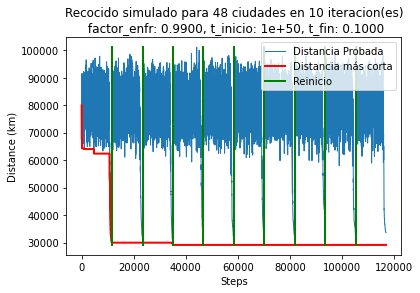

In [7]:
# para garantizar reproducibilidad 
random.seed(42)

# inicialice los parámetros del recocido simulado
# tempetatura inicial
temperature_start = 1e+50
# tempetatura final
temperature_end = 0.1
# factor de enfriamiento
cooling_factor = 0.99
# numero de iteraciones
nb_iterations = 10

# Seleccionamos la longitud inicial del tour. Note que en Gurobi se incluyeron todas las ciudades (48)
# y se relajaron las restricciones para poder encontrar el óptimo. En ese caso, nb_cities = len(capitals)
nb_cities = len(capitals)
print("Empezando Recocido Simulado, presione CTRL+C para interrumpir...")
# ruta inicial, puede ser seleccionada al azar 
time_begin = time.time()
cities = random.sample(capitals, nb_cities)
(cities_new, distances_current, distances_best, ids_iteration) = annealing(cities, temperature_start, temperature_end, cooling_factor, nb_iterations)
time_end = time.time()

distance_begin = total_distance_in_km(cities)
distance_end = total_distance_in_km(cities_new)
print("Mejora:            {:>8.2f} %".format(100 * (distance_begin - distance_end) / distance_begin))
print("Tiempo:            {:>8.4f} sec".format(time_end - time_begin))
print("Distancia Inicial: {:>8.2f} km".format(distance_begin))
print("Distancia Final:   {:>8.2f} km".format(distance_end))

plot_distances(distances_current, 3, distances_best, ids_iteration, len(cities), nb_iterations, cooling_factor, temperature_start, temperature_end)

# mostramos la solución. 
map = folium.Map(location=[40,-95], zoom_start = 4)

points = []
for city in cities_new:
    points.append(coordinates[city])
points.append(points[0])

folium.PolyLine(points).add_to(map)

map

**Ejercicio propuesto: Juegue con los diferentes parámetros del recocido simulado. Puede encontrar una solución que se aproxime a la óptima?**

### Solución al TSP usando algoritmos genéticos

Inspirados en la selección natural, los algoritmos genéticos (AG) son un enfoque fascinante para resolver problemas de búsqueda y optimización.

Recordemos que para hacer uso de este tipo de algoritmos debemos definir primero un par de conceptos. 

* A cada ciudad (o a sus coordenadas $x$ e $y$) la representaremos con un **gen**.
* A una ruta que satisface las condiciones dadas por el TSP la llamaremos **individuo**, más conocido como **cromosoma**. 
* A un conjunto de rutas válidas lo llamaremos **población**.
* A un par de rutas que se combinan para crear nuevas rutas las llamaremos rutas **padres**. 
* A un conjunto de padres que son usados para crear la próxima generación de rutas lo llamaremos **grupo de apareamiento**.
* A la función que nos dice que tan buena es cada ruta (cuán corta es la distancia de la ruta) la llamaremos **fitness**.
* Una **mutación** estará definida por el intercambio de dos ciudades en la ruta. 
* La manera de seleccionar los mejores individuos para la siguiente generación será por **elitismo**, es decir, sólo las rutas más cortas podrán ser seleccionadas. 

Podemos resumir el algoritmo genético en los siguientes pasos: 
1. Crear la población
2. Determinar la aptitud
3. Seleccionar el grupo de apareamiento
4. Criar
5. Mutar
6. Repetir

**Nota: reutilizaremos la mayor parte de las funciones que fueron creadas**


In [8]:
# Seleccionamos la longitud inicial del tour. Note que en Gurobi se incluyeron todas las ciudades (49)
# y se relajaron las restricciones para poder encontrar el óptimo. En ese caso, nb_cities = len(capitals)
nb_cities = len(capitals)

# Creamos la población, al igual que el recocido simulado, esta puede ser seleccionada al azar
# recuerde que una población es un conjunto de rutas, por lo que tendremos que crear rutas aleatorias varias veces. 

# Note que sólo tenemos que crear la población inicial, puesto que las siguientes generaciones 
# serán creadas a través de apareamiento y mutación. 

def create_route(city_list):
    route = random.sample(city_list, len(city_list))
    return route

def initial_population(pop_size, city_list):
    population = []
    for i in range(0, pop_size):
        population.append(create_route(city_list))
    return population

# Como lo que se quiere es minimizar la distancia de la ruta, 
# una función inversa de la distancia va mejor como fitness
def route_fitness(distance):
    fitness = 1 / float(distance)
    return fitness

# Le asignamos un puntaje a cada ruta. Devolvemos una lista con los indices de las rutas mejor puntuadas
def rank_population(population):
    fitness_results = {}
    for i in range(0, len(population)):
        fitness_results[i] = route_fitness(total_distance_in_km(population[i]))
    return sorted(fitness_results.items(), key = operator.itemgetter(1), reverse = True)

# Devolvemos los mejores individuos (mejores rutas). 
# Otras estrategias de selección pueden ser implementadas en esta función. 
def selection(population, ranked_population):
    mating_pool = []
    for items in ranked_population:
        index_route = items[0]
        rank = items[1]
        mating_pool.append(population[index_route])
    return mating_pool

**Ejercicio propuesto: Para la selección de los mejores individuos, en este notebook usamos elitismo puro, es decir, que sólo las rutas mejores puntuadas son seleccionadas para construir el grupo de apareamiento. Modifique el código necesario para implementar un método de selección diferente (ej., selección de torneo, o selección proporcional). Que efecto tiene el método de selección en: 1) la calidad de la solución?, 2) el tiempo de búsqueda?**

Con nuestro grupo de apareamiento, podemos crear la siguiente generación en un proceso llamado cruce (también conocido como "reproducción"). Si nuestros individuos fueran cadenas de 0 y 1 y no se aplicaran nuestras dos reglas, podríamos simplemente elegir un punto de cruce y empalmar las dos cadenas para producir una descendencia.

Sin embargo, en el TSP tenemos que incluir en la ruta todas las ciudades exactamente una vez. Para cumplir esta regla, podemos utilizar una función de cruce especial llamada cruce ordenado. En el cruce ordenado, seleccionamos aleatoriamente un subconjunto de la primera cadena del padre y luego llenamos el resto de la ruta con los genes del segundo padre en el orden en que aparecen, sin duplicar ningún gen en el subconjunto seleccionado del primer padre, como lo muestra la figura más abajo.

![alt text](https://miro.medium.com/max/700/1*YhmzBBCyAG3rtEBbI0gz4w.jpeg)

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    start_gene = min(geneA, geneB)
    end_gene = max(geneA, geneB)

    for i in range(start_gene, end_gene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

# Ahora necesitamos generalizar para reproducir unicamente los mejores individuos. 

def breed_population(mating_pool, elite_size):
    children = []
    length = len(mating_pool) - elite_size
    pool = random.sample(mating_pool, len(mating_pool))

    # Se garantiza que los mejores individuos pasen a la siguiente generación. 
    for i in range(0, elite_size):
        children.append(mating_pool[i])
    
    # El resto de la población se muta para tratar de obtener mejores individuos
    for i in range(0, length):
        child = breed(pool[i], pool[len(mating_pool)-i-1])
        children.append(child)
    return children

**Ejercicio propuesto: Cambie el operador de cruce por otro (ej., cruce uniforme), teniendo en cuenta las reglas que se deben cumplir en el TSP. Que efecto tiene el operador de cruce en: 1) la calidad de la solución?, 2) el tiempo de búsqueda?**

La mutación cumple una función importante en los AG, ya que ayuda a evitar que el algoritmo quede atrapado en óptimos locales introduciendo nuevas rutas que nos permitirán explorar otras partes del espacio de soluciones. Al igual que el cruce, el TSP tiene una consideración especial cuando se trata de la mutación. De nuevo, si tuviéramos un cromosoma de 0s y 1s, la mutación significaría simplemente asignar una probabilidad baja de que un gen cambie de 0 a 1, o viceversa.

Sin embargo, como tenemos que respetar nuestras reglas, no podemos dejar de lado las ciudades. En su lugar, utilizaremos una mutación basada en el intercambio de ciudades. Esto significa que, con una probabilidad baja especificada, dos ciudades se intercambiarán en nuestra ruta. Haremos esto para un individuo en nuestra función de mutación y luego extenderemos para incluir toda la población. 

In [10]:
import copy

# Mutación de un individuo basada en el intercambio de dos ciudades.
def mutate(individual, mutation_rate):
    for swapped in range(len(individual)):
        # aleatoriamente seleccionamos un número, si es menor que la tasa de mutación, haremos el cambio. 
        if(random.random() < mutation_rate):
            swap_with = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swap_with]
            
            individual[swapped] = city2
            individual[swap_with] = city1
    return individual

def mutate_population(population, mutation_rate):
    mutated_pop = []
    
    for ind in range(0, len(population)):
        mutated_ind = mutate(population[ind], mutation_rate)
        mutated_pop.append(mutated_ind)
    return mutated_pop

# El proceso que hemos venido construyendo se debe repetir por varias generaciones. 
def next_generation(current_gen, elite_size, mutation_rate):
    pop_ranked = rank_population(current_gen)
    matingpool = selection(current_gen, pop_ranked)
    children = breed_population(matingpool, elite_size)
    next_generation = mutate_population(children, mutation_rate)
    return next_generation

# Finalmente ponemos el algoritmo en una sola función
def genetic_algorithm(cities, pop_size, elite_size, mutation_rate, generations):
    pop = initial_population(pop_size, cities)
    ranking_pop = rank_population(pop)
    best_initial_route = copy.copy(pop[ranking_pop[0][0]])
    print(f"Mejor ruta de la población inicial: {best_initial_route}")
    progress = []
    progress.append(1 / ranking_pop[0][1])    
    
    for i in range(0, generations):
        pop = next_generation(pop, elite_size, mutation_rate)
        progress.append(1 / rank_population(pop)[0][1])
    
    best_route_index = rank_population(pop)[0][0]
    best_route = pop[best_route_index]
    
    # mostrar la mejora
    plt.plot(progress)
    plt.ylabel('Distancia')
    plt.xlabel('Generación')
    plt.show()
    return best_route, best_initial_route

Empezando Algoritmo Genético
Lista de ciudades a visitar: ['Austin', 'Tallahassee', 'Phoenix', 'Annapolis', 'Baton Rouge', 'Frankfort', 'Atlanta', 'Dover', 'Salem', 'Hartford', 'Columbia', 'Trenton', 'Little Rock', 'Charleston', 'Pierre', 'Topeka', 'Montpelier', 'Augusta', 'Lansing', 'Montgomery', 'Olympia', 'Cheyenne', 'Jefferson City', 'Saint Paul', 'Carson City', 'Providence', 'Columbus', 'Madison', 'Bismarck', 'Boston', 'Salt Lake City', 'Santa Fe', 'Oklahoma City', 'Indianapolis', 'Concord', 'Richmond', 'Denver', 'Harrisburg', 'Sacramento', 'Des Moines', 'Nashville', 'Raleigh', 'Boise', 'Jackson', 'Springfield', 'Lincoln', 'Helana', 'Albany']
Mejor ruta de la población inicial: ['Albany', 'Lansing', 'Phoenix', 'Austin', 'Montgomery', 'Denver', 'Sacramento', 'Atlanta', 'Cheyenne', 'Helana', 'Boston', 'Concord', 'Indianapolis', 'Santa Fe', 'Salem', 'Oklahoma City', 'Harrisburg', 'Richmond', 'Nashville', 'Providence', 'Annapolis', 'Columbia', 'Frankfort', 'Saint Paul', 'Pierre', 'Oly

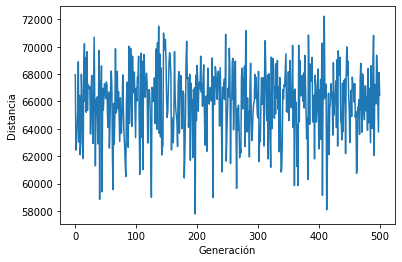

************** Resumen ***************
Tiempo:                                               5.8270 sec
Distancia Inicial:                                  84205.01 km
Distancia de la mejor ruta de la población inicial: 67952.70 km
Distancia Final:                                    66451.18 km
Mejora respecto a lista inicial de ciudades:           21.08 %
Mejora respecto a mejor ruta inicial:                   2.21 %


In [11]:
import operator
# para garantizar reproducibilidad 
random.seed(42)

# inicialice los parámetros del algoritmo genético
# tamaño de la población. Este tamaño indica cuantos inidividuos (rutas) se generan en cada generación. 
pop_size = 100
# tamaño de la población élite. Este tamaño indica cuantos inidividuos (rutas) se seleccionan para ser padres de la 
# siguiente generación. Note que elite_size <= pop_size
elite_size = 20
# tasa de mutación. Este porcentaje indica que tanto una ruta es cambiada. 
mutation_rate = 0.5
# cantidad de generaciones (iteraciones)
generations = 500

# Seleccionamos la longitud inicial de las rutas. Note que en Gurobi se incluyeron todas las ciudades (48)
# y se relajaron las restricciones para poder encontrar el óptimo. En ese caso, nb_cities = len(capitals)
nb_cities = len(capitals)
print("Empezando Algoritmo Genético")
# ruta inicial, puede ser seleccionada al azar. Si queremos rutas mas cortas, solo hay que cambiar nb_cities
time_begin = time.time()
cities = random.sample(capitals, nb_cities)
print(f"Lista de ciudades a visitar: {cities}")
best_route, best_initial_route = genetic_algorithm(cities=cities, pop_size=pop_size, elite_size=elite_size, mutation_rate=mutation_rate, generations=generations)
time_end = time.time()

distance_begin = total_distance_in_km(cities)
distance_best_initial_route = total_distance_in_km(best_initial_route)
distance_end = total_distance_in_km(best_route)

print("************** Resumen ***************")
print("Tiempo:                                             {:>8.4f} sec".format(time_end - time_begin))
print("Distancia Inicial:                                  {:>8.2f} km".format(distance_begin))
print("Distancia de la mejor ruta de la población inicial: {:>8.2f} km".format(distance_best_initial_route))
print("Distancia Final:                                    {:>8.2f} km".format(distance_end))
print("Mejora respecto a lista inicial de ciudades:        {:>8.2f} %".format(100 * (distance_begin - distance_end) / distance_begin))
print("Mejora respecto a mejor ruta inicial:               {:>8.2f} %".format(100 * (distance_best_initial_route - distance_end) / distance_best_initial_route))


# mostramos la solución. 
map = folium.Map(location=[40,-95], zoom_start = 4)

points = []
for city in best_route:
    points.append(coordinates[city])
points.append(points[0])

folium.PolyLine(points).add_to(map)

map

**Ejercicio propuesto: Juegue con los diferentes parámetros del algoritmo genético. Puede encontrar una solución que se aproxime a la óptima?**

## Conclusiones

En este notebook solucionamos el problema del vendedor viajero (TSP) en varias formas. Primero, encontramos la solución óptima por medio de Gurobi, haciendo algunas relajaciones. Luego, usamos el recocido simulado y el algoritmo genético para tratar de encontrar soluciones que se aproximen al óptimo. 

En el notebook también encontrarán algunos ejercicios propuestos que los llevará a realizar un análisis más detallado acerca de la solución óptima y su tiempo de búsqueda y las soluciones encontradas por las otras metaheurísticas. 

Finalmente, **podrías implementar alguna otra metaheurística para resolver el TSP?**

## Referencias

[1] https://www.gurobi.com/resource/traveling-salesman-problem/

[2] https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

[3] https://codecapsule.com/2010/04/06/simulated-annealing-traveling-salesman/

[4] D. L. Applegate, R. E. Bixby, V. Chvatal and W. J. Cook , The Traveling Salesman Problem: A Computational Study, Princeton University Press, Princeton, 2006.

[5] http://www.math.uwaterloo.ca/tsp/index.html

[6] https://www.youtube.com/watch?v=q8nQTNvCrjE&t=35s

[7] https://www.w3schools.com/python/python_json.asp

[8] https://developers.google.com/optimization/routing/tsp
